In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [3]:
from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target # each digit image is represented as a 784-dimensional vector (28*28 pixels)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [4]:
X.shape # 784 features, 70000 samples, each sample is a 28*28 pixel image

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [6]:
y.shape

(70000,)

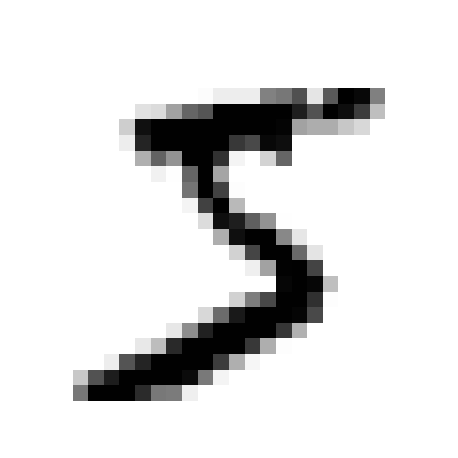

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0] # X[0, :]
plot_digit(some_digit)
save_fig("some_digit_plot")  
plt.show()

In [8]:
y[0]

'5'

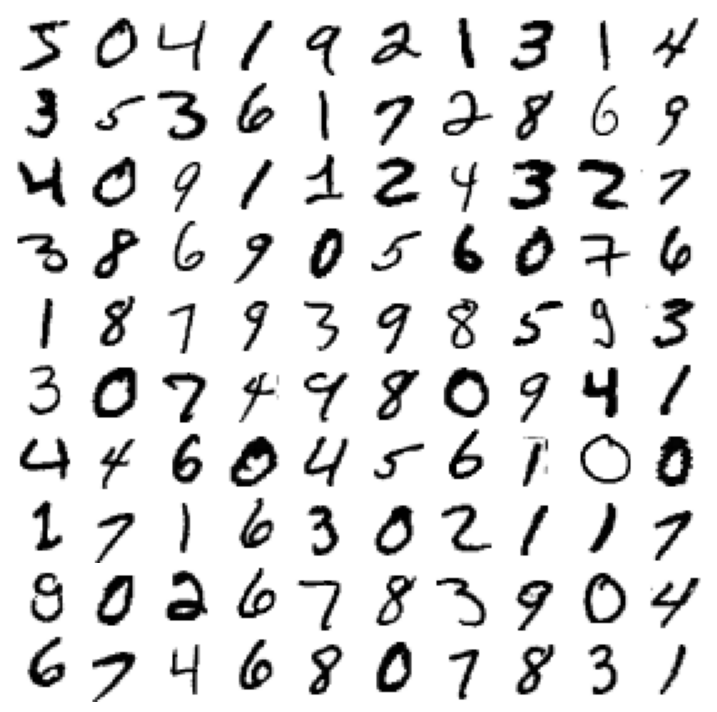

In [9]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [11]:
y_train_5 = (y_train == '5') # New boolean array, if 5 then true, else false
y_test_5 = (y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5) # learns to detect 5s, not other digits

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.dummy import DummyClassifier
# DummyClassifier is a classifier that makes predictions using simple rules, such as always predicting the most frequent class or making random predictions. It is often used as a baseline to compare the performance of more complex classifiers.
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 90% accuracy is not very good when detecting 5s, because only 10% of the images are 5s, so if you always predict "not 5", you will be right 90% of the time!
# it means that the SGDClassifier is not doing much better than the DummyClassifier, which is a sign that it is not learning anything useful from the data.
# so accuracy is not a good metric to evaluate a classifier
# instead we use the confusion matrix

array([0.90965, 0.90965, 0.90965])

## Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross_val_predict() performs K-fold cross validation, but instead of returning the evaluation scores
# it returns the predictions made on each test fold. This allows us to get a prediction for each instance in the training set, which we can then use to compute the confusion matrix and other metrics.
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_train_5, y_train_pred)
cm 

cm_df = pd.DataFrame(
    cm, 
    index=['Actual Not-5', 'Actual 5'], 
    columns=['Predicted Not-5', 'Predicted 5']
)

print(cm_df)

              Predicted Not-5  Predicted 5
Actual Not-5            53892          687
Actual 5                 1891         3530


- 53892 correctly classified as non 5 (TN)
- 678 wrongly classified as 5 (FP)
- 1891 wrongly classified as non 5 (FN)
- 3530 correctly classified as 5 (TP)

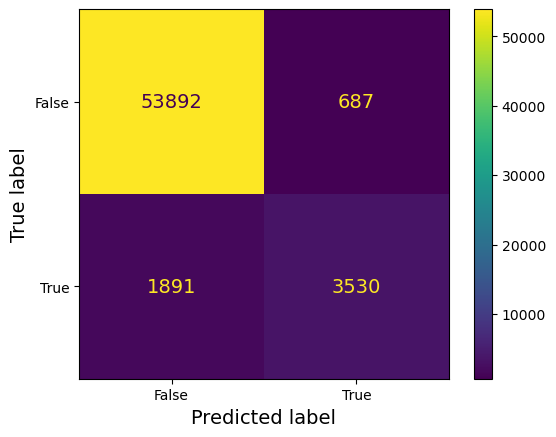

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_5, y_train_pred)
plt.show()

In [20]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score
# TP / (TP + FP), percentage of correctly classified 5s out of all the images classified as 5s
# so among all images predicted as 5s, how many are actually 5s?
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [22]:
# TP / (TP + FN), percentage of correctly classified 5s out of all the images that are actually 5s
# so among all the images that are actually 5s, how many did we correctly classify as 5s?
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [23]:
from sklearn.metrics import f1_score 
# The F1 score is the harmonic mean of precision and recall, which gives a single score that balances both metrics. It is defined as 2 * (precision * recall) / (precision + recall). 
# A high F1 score means that the classifier has both high precision and high recall.
f1_score(y_train_5, y_train_pred)
# A good F1 score is between 0.5 and 1, with 1 being perfect precision and recall. In this case, the F1 score is around 0.75, which indicates that the classifier is doing a decent job at detecting 5s, but there is still room for improvement.

0.7325171197343847

Increasing precision reduces recall and viceversa

## Precision/Recall Trade-off
- if we raise the threshold we pick the image only if we are extremely confident, fewer false positives so the precision goes higher, but recall lower
- if we lower the threshold we want to make sure we don't miss any 5s, so we get more false positives and therefore precision goes lower and recall goes higher

so it depends on scenario by scenario, sometimes we want high precision(we want to be sure that what we pick is positive), other times high recall (we want to pick every positive case)

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores # a score > 0 means that the classifier thinks it is a 5, < 0 means it thinks it is not a 5, and the magnitude of the score indicates how confident the classifier is in its prediction.
# 0 is the default threshold, but you can choose a different threshold to get better precision or recall. For example, if you want to get 90% precision, you can find the threshold that gives you that precision and then use it to make predictions.

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [26]:
y_some_digit_pred  

array([ True])

In [27]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")
# I get the decision scores for each instance in the training set using cross_val_predict() with method="decision_function". This allows me to compute precision and recall for all possible thresholds and plot the precision-recall curve, which helps me choose the best threshold for my classifier.

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# precisions and recalls are arrays containing the precision and recall values for all possible thresholds. The thresholds array contains the corresponding threshold values. By plotting these values, we can visualize the trade-off between precision and recall and choose the threshold that best suits our needs.

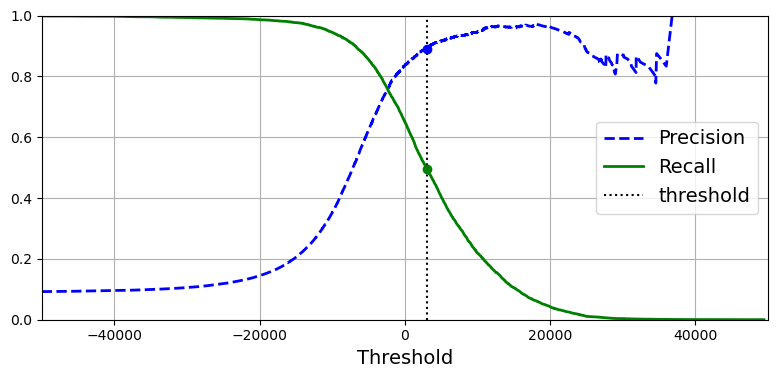

In [30]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Recall can only go down when we increase the threshold, but this is not said for precision

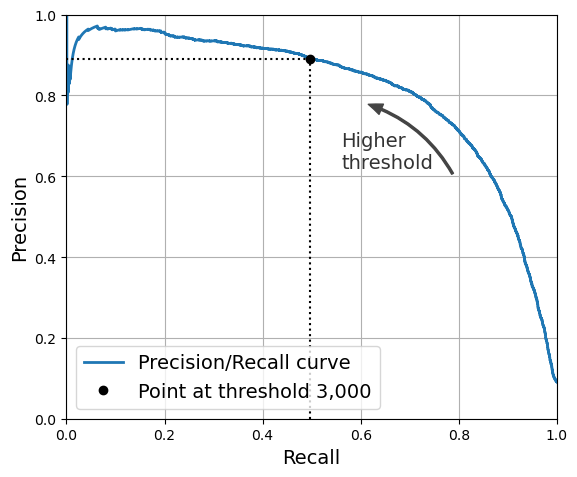

In [31]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [32]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439594)

In [33]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
# only label as True (5) if its score is higher then 3370 or higher
# to have a 90% or higher precision 

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

Tool for Binary Classifiers, which plots the recall (sensitivity) curve and the false positive rate (1 - specificity) = FP / (FP + TN):It measures the proportion of actual negatives that were incorrectly classified as positives

In [36]:
from sklearn.metrics import roc_curve
# thresholds is the array of threshold values
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

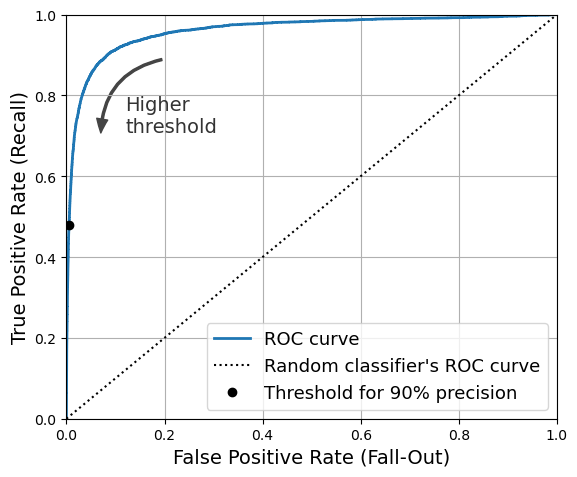

In [37]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [40]:
# the first column contains the probability that the classifier assigned to the negative class (not 5), and the second column contains the probability that it assigned to the positive class (5).
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [41]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

the first image is positive with 89% prob and  the second negative with 99% prob

In [42]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

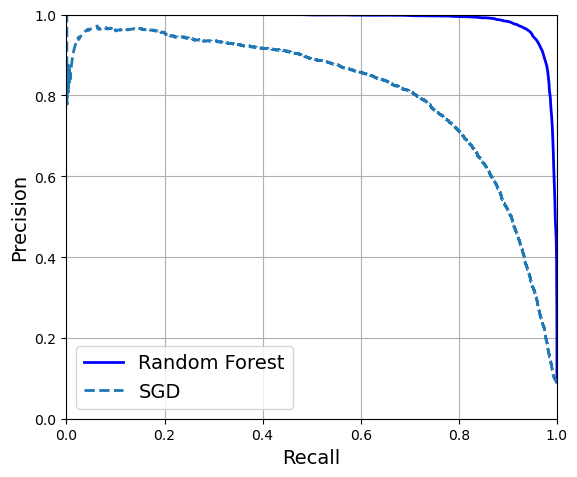

In [43]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [44]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [45]:
# the actual target and the probability scores are used to compute the ROC AUC score, 
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [46]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass Classification

Some Scikit-Learn are capable of handling multiclasses natively

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) 
# SVC is not good at handling large datasets
# so we use only the first 2000 instances to train it
# otherwise it would take a very long time


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [49]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [50]:
# decision_function() method returns the distance of the input samples to the decision boundary. The farther away from the boundary, the more confident the classifier is in its prediction. A positive score means that the classifier predicts the positive class (5), while a negative score means that it predicts the negative class (not 5).
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [51]:
# argmax() method returns the index of the maximum score
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [52]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [53]:
svm_clf.classes_[class_id]

'5'

In [54]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [56]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [59]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [62]:
# cm = confusion_matrix(y_train, y_train_pred)
# cm 

In [63]:
# precision_score(y_train, y_train_pred, average="macro")

In [64]:
# recall_score(y_train, y_train_pred, average="macro")

In [65]:
# from sklearn.metrics import classification_report
# print(classification_report(y_train, y_train_pred))

# Error Analysis
How do I improve my model?

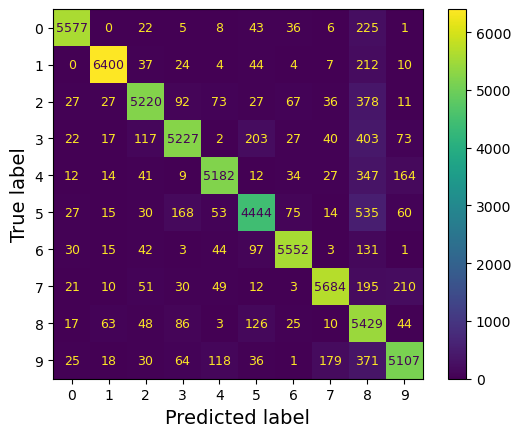

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

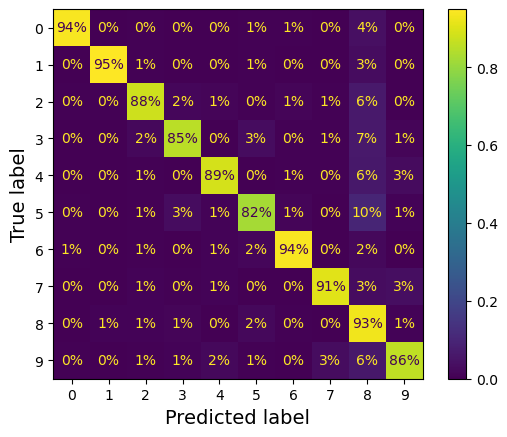

In [67]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

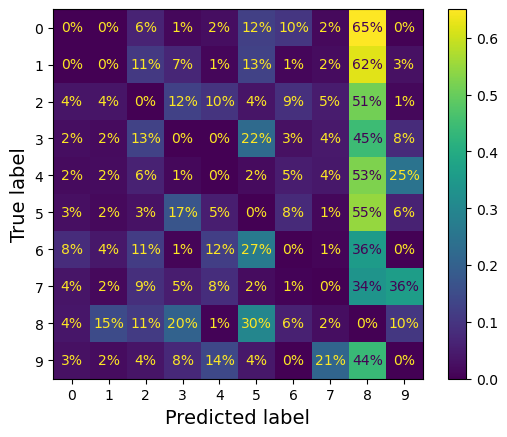

In [68]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

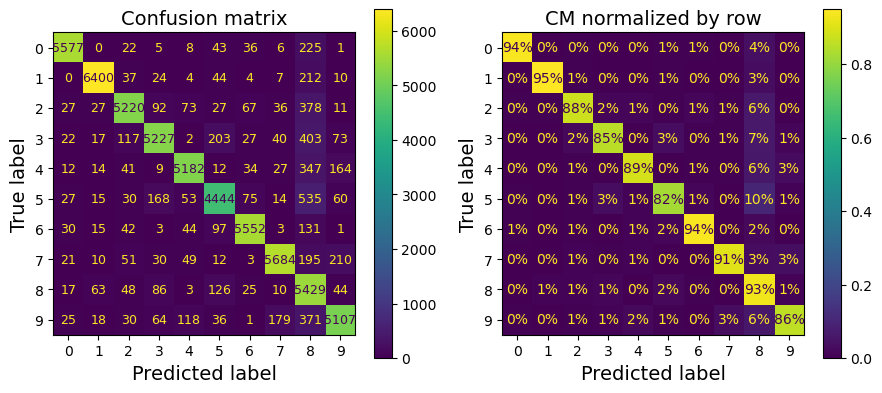

In [69]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

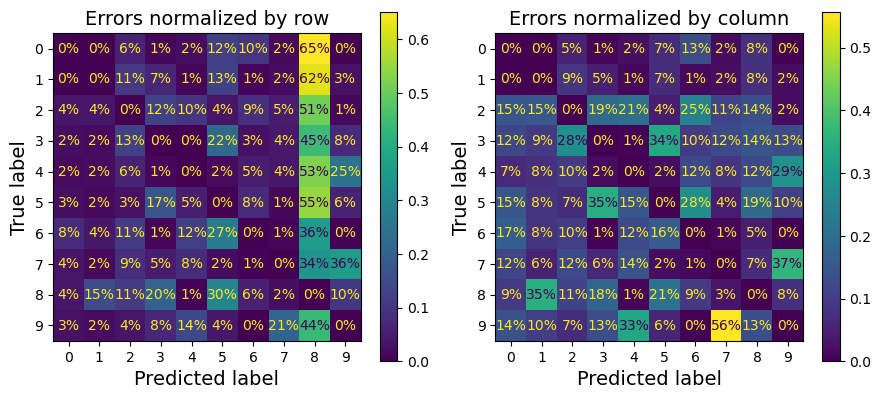

In [70]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

Many non eights are predicted as eight

In [71]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

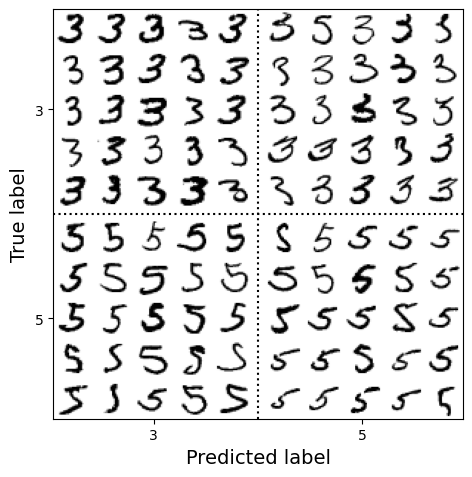

In [72]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification
Instance may belong to multiple classes

In [73]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1) 
# np.c_() function is used to concatenate two arrays along the second axis (columns) to create a new array with two columns, where the first column contains the boolean values indicating whether the digit is greater than or equal to 7, and the second column contains the boolean values indicating whether the digit is odd.
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [74]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [76]:
from sklearn.metrics import classification_report

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
print(classification_report(y_multilabel, y_train_knn_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18065
           1       0.97      0.99      0.98     30508

   micro avg       0.97      0.98      0.98     48573
   macro avg       0.97      0.98      0.98     48573
weighted avg       0.97      0.98      0.98     48573
 samples avg       0.59      0.59      0.59     48573



c:\Users\YeXiaoJun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\YeXiaoJun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\YeXiaoJun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [77]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [78]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification
Multilabel classifier where each instance can belong to multiple classes

In [79]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

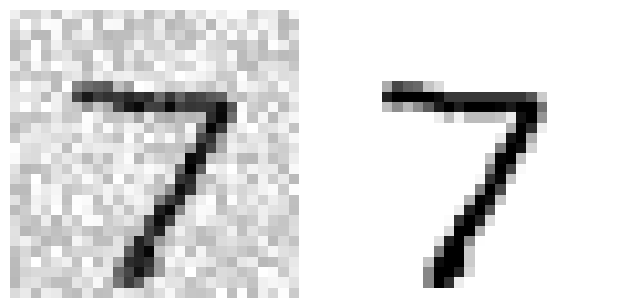

In [80]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

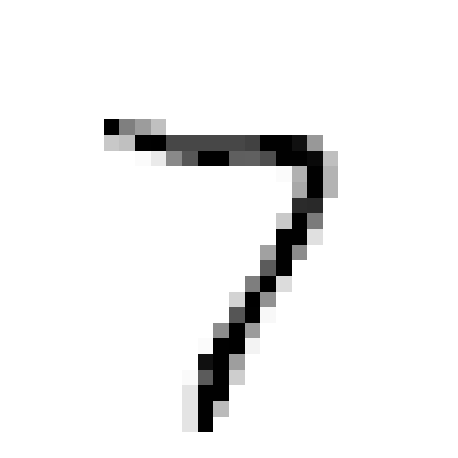

In [81]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercise 1

In [83]:
from sklearn.model_selection import GridSearchCV
#X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

knn_clf = KNeighborsClassifier()

param_grid = [
    {'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,4


In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [85]:
grid_search.best_score_

np.float64(0.9437666666666668)

In [86]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714